# 1. Local CpGs enriched in EWAS for a specific phenotype?
- Latent features correlate with phenotypes
- Associated CpGs do the same?

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle 
import torch
from data.prepareData import prepareDataLoader_fromPkl
from scripts.train_RFregressor import RFregression
import random
import copy

from scipy.stats import pearsonr
import json

from scipy.stats import mannwhitneyu

sns.set_theme(style="ticks", font_scale=1.8)

In [4]:
def traits_per_latFeature(idx_cpgs, verbose=True):
    '''
    Get all (high) CpGs of each latent feature and see which traits they are associated to!
    '''
    notavailable = 0
    latFeature_alltraits = []
    for ele in idx_cpgs: 
        try:
            latFeature_alltraits.append(dic_cpgs[ele])
        except KeyError:
            notavailable+=1
            continue
    traits_latFeature = pd.Series(np.concatenate(latFeature_alltraits)).value_counts()

    if verbose:
        print(f"Number of CpGs associated to latent feature: {len(idx_cpgs)}")
        print(f"Number of CpGs present in EWAS and taken into account for analysis: {len(idx_cpgs)-notavailable}")

    return traits_latFeature, len(idx_cpgs)-notavailable

In [5]:
''' 
Pipeline: Latent feature and associated traits + bootstrapping for significance: 
(estimate (random) occurence of top 10 traits for each latent feature CpG combination)
'''

def pipeline_latFeature_trait_association(latFeature, iter=1000):
    print(latFeature)
    ### Step 1: Get latent feature its associated traits (top 10)
    idx_cpgs = conn.loc[latFeature,:][conn.loc[latFeature,:] == 3].index.tolist()
    traits_latFeature, numCpGsAnalysed = traits_per_latFeature(idx_cpgs)
    #print(traits_latFeature[:10])

    ### Step 2: prepare which trait to consider and result dic
    # Prepare
    num_random = numCpGsAnalysed
    pool_draw = idx_cpgs_high_ewas          ## only take CpGs into account that are highly connected (=meaningful) and also in EWAS; we want to see if onyl phenotype is enriched, nto the signal, so this comparison is fair I think
    traits2consider = traits_latFeature[:10].index.tolist()         ## only first 10 traits to reduce noise
    dic_occ = dict.fromkeys(traits2consider)            ## initialise result dic

    ### Step 3: Randomly sample the same number of CpGs and check for traits: what is the occurrence there?
    for i in range(iter):
        # Draw & Get traits
        rand = random.sample(pool_draw,num_random)
        traits_rand, _ = traits_per_latFeature(rand, verbose=False)

        # Record result
        ### Step 1: record trait occurences of CpGs
        for ele in traits_rand.index:
            if ele in dic_occ.keys():
                if dic_occ[ele] is None: 
                    dic_occ[ele] = [traits_rand[ele]]
                else:
                    dic_occ[ele].append(traits_rand[ele])

        ### Step 2: Fill up missing traits with "0"
        for key, val in dic_occ.items():
            if key not in traits_rand.index:
                if dic_occ[key] is None:
                    dic_occ[key] = [0]
                else: 
                    dic_occ[key].append(0)

    ### Step 4: Conduct bootstrap test on significance
    dic_pvals = dict()
    for trait in dic_occ.keys():
        thresh = traits_latFeature[trait]
        num_significant = np.array(dic_occ[trait])[np.array(dic_occ[trait]) >= thresh]
        pval = len(num_significant) / iter  ### iterations
        dic_pvals[trait] = pval
        #print(f"Bootstrap test for ### {trait} ({round(thresh, 2)})###: \t{len(num_significant)}/{iter}; \tp-Value = {pval}")

    ### Step 5: prepare final result dataframe for latent feature
    df = pd.DataFrame(traits_latFeature[:10], columns=["associatedCpGs"])           #[:10]
    df["meanRandomCpGs"] = list(map(lambda key: np.array(dic_occ[key]).mean(), dic_occ.keys()))
    df["pval_bootstrap"] = dic_pvals.values()
    df.sort_values(["pval_bootstrap"], inplace=True)        

    return df, dic_occ

# Staaart

In [11]:
### Read in EWAS results from EWAS cataloge (all results!)
ewas = pd.read_table("../EWAScatalogue/ewascatalog-results.txt", low_memory=False)
studies = pd.read_table("../EWAScatalogue/ewascatalog-studies.txt")

In [12]:
for CHR in [f"chr{i}" for i in range(1,23)]: #13
    print(CHR)
    PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
    PATH_model= f"logs/finalModels/{CHR}"
    PATH_perturbation = f"results/{CHR}/perturbations"
    conn = pd.read_csv(f"{PATH_perturbation}/quantileCutoff_CpGfocus.csv", index_col=0)
    
    ''' 
    Load EWAS catalogue
    '''
    studies_filtered = studies[(studies["Tissue"] == "Whole blood")]
    ewas_studies = ewas[ewas["StudyID"].isin(studies_filtered["StudyID"])]
    ewas_studies = ewas_studies[ewas_studies["Chr"] == str(CHR.split("r")[1])]

    print(f"Number of EWAS studies reported:\t{len(ewas_studies)}")
    print(f"Number of CpGs reported:\t{len(ewas_studies['CpG'].unique().tolist())}")
    
    ''' 
    Get all CpGs that show high connection to some latent feature (=3)
    '''
    idx_cpgs_high = conn.columns[(conn == 3).sum() > 0].tolist()
    
    ''' 
    Get all CpGs that are also in EWAS
    '''
    idx_cpgs_high_ewas = [i for i in idx_cpgs_high if i in ewas_studies["CpG"].unique().tolist()]
    print(f"CpGs with high perturbation \t total: {len(idx_cpgs_high)} CpGs \t EWAS catalogue: {len(idx_cpgs_high_ewas)} CpGs\t Ratio: {round((len(idx_cpgs_high_ewas)/len(idx_cpgs_high))*100,1)} %")
    
    ''' 
    Get all phenotypes cpgs (dic_traits) are annotated to and all annotations for each cpg (dic_cpgs)
    '''
    dic_traits = dict()
    dic_cpgs = dict()
    for cpg in idx_cpgs_high_ewas:
        studyids = ewas_studies[ewas_studies["CpG"].isin([cpg])]["StudyID"]
        traits = studies_filtered[studies_filtered["StudyID"].isin(studyids)]["Trait"].tolist()
        ### Fill dictionary: "cpg" = [traits]
        dic_cpgs[cpg] = traits
        ### Fill dictionary: "trait" = [cpgs]
        for i in traits: 
            if i in dic_traits.keys(): dic_traits[i].append(cpg)
            else: dic_traits[i] = [cpg]
                
    save=True
    for i in range(conn.shape[0]):
        df, dic_occ = pipeline_latFeature_trait_association(f"latFeature_{i}", iter=1000) ### 5000
        #print(df[df["pval_bootstrap"] < 0.05])
        #print("\n\n")

        ### save results
        if save:
            PATH_results = f"{PATH_perturbation}/localCpG_EWAStraitAssociation/latFeature_{i}"
            os.makedirs(PATH_results, exist_ok=True)
            df.to_csv(f"{PATH_results}/latFeature_traitAssociation_using_EWAS.csv")

chr1
Number of EWAS studies reported:	134648
Number of CpGs reported:	46982
CpGs with high perturbation 	 total: 6777 CpGs 	 EWAS catalogue: 6427 CpGs	 Ratio: 94.8 %
latFeature_0
Number of CpGs associated to latent feature: 392
Number of CpGs present in EWAS and taken into account for analysis: 359
latFeature_1
Number of CpGs associated to latent feature: 390
Number of CpGs present in EWAS and taken into account for analysis: 352
latFeature_2
Number of CpGs associated to latent feature: 528
Number of CpGs present in EWAS and taken into account for analysis: 494
latFeature_3
Number of CpGs associated to latent feature: 394
Number of CpGs present in EWAS and taken into account for analysis: 357
latFeature_4
Number of CpGs associated to latent feature: 339
Number of CpGs present in EWAS and taken into account for analysis: 314
latFeature_5
Number of CpGs associated to latent feature: 424
Number of CpGs present in EWAS and taken into account for analysis: 403
latFeature_6
Number of CpGs as

KeyboardInterrupt: 

# Plot

In [20]:
'''
AGE
 - get correlation of each latent feature with AGE
 - plot pval association vs correlation with phenotype
 --> expect negative linear correlation
'''

df_plot = pd.DataFrame()

for CHR in [f"chr{i}" for i in range(13,23)]:
    print(CHR)
    PATH_perturbation = f"results/{CHR}/perturbations"
    ### Load model
    PATH_model= f"logs/finalModels/{CHR}"
    with open(f"{PATH_model}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
    ###########################################
    latSize = dict_bestModel["latentSize"]   ####25
    ###########################################
    name = f"latSize_{latSize}"
    model = torch.load(f"{PATH_model}/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

    ### Get the correlation of a latent feature with the phenotype
    pheno = "Age"
    PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: dataset = pickle.load(f) #
    y_age = dataset["pheno"][pheno]
    y_age = y_age.replace(np.nan, y_age.median())  ## impute missing values for simplicity

    ### Generate latSpace
    test_tensor = torch.tensor(dataset["beta"].values, dtype=torch.float32)
    with torch.no_grad():
        latSpace = model.generate_embedding(test_tensor)

    ### Correlation between latActivations (over all patients) and Age
    all_pearson = []
    for i,val in enumerate(latSpace.T):
        all_pearson.append(np.absolute(pearsonr(val, y_age)[0]))
    df_age_activations = pd.DataFrame(all_pearson, columns=["pearson"]).sort_values(by="pearson", ascending=False)

    ### Latent feature trait association with phenotype
    for i in range(latSize):
        ## Load trait associations
        PATH_traitAssoc = f"{PATH_perturbation}/localCpG_EWAStraitAssociation/latFeature_{i}/latFeature_traitAssociation_using_EWAS.csv"
        df_traitAssoc = pd.read_csv(f"{PATH_traitAssoc}", index_col=0)
        ## Get all traits related to "age" and get mean of pval
        pval_mean = df_traitAssoc[df_traitAssoc.index.str.contains("age*", case=False)]["pval_bootstrap"].mean()
        ## add to table
        df_age_activations.loc[i, "pval_traitAssoc"] = pval_mean
    df_plot = pd.concat([df_plot,df_age_activations], ignore_index=True)

chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


(-0.05, 1.05)

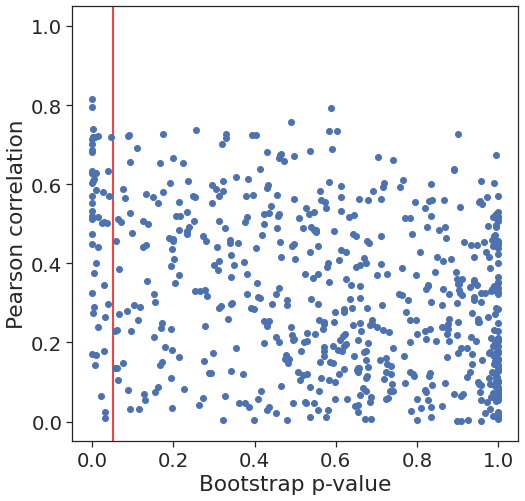

In [21]:
df_plot2 = df_plot.copy()
fig, ax = plt.subplots(figsize=(8,8))
ax.vlines(0.05, -.1, 1.1, "red")
ax.plot(df_plot2["pval_traitAssoc"],df_plot2["pearson"], "o")
ax.set_ylabel("Pearson correlation")
ax.set_xlabel("Bootstrap p-value")
ax.set_xlim(-.05,1.05)
ax.set_ylim(-.05,1.05)

In [13]:
'''
Sex
 - get correlation of each latent feature with AGE
 - plot pval association vs correlation with phenotype
 --> expect negative linear correlation
'''

df_plot = pd.DataFrame()

for CHR in [f"chr{i}" for i in range(13,23)]:
    print(CHR)
    PATH_perturbation = f"results/{CHR}/perturbations"
    ### Load model
    PATH_model= f"logs/finalModels/{CHR}"
    with open(f"{PATH_model}/param_grid.json", "r") as f: dict_bestModel = json.load(f)
    ###########################################
    latSize = dict_bestModel["latentSize"]   ####25
    ###########################################
    name = f"latSize_{latSize}"
    model = torch.load(f"{PATH_model}/{name}/checkpoint/trainedModel.pth", map_location=torch.device('cpu'))

    ### Get the correlation of a latent feature with the phenotype
    pheno = "Sex"
    PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
    with open(os.path.join(PATH_data, f"{CHR}_test_methyl_array.pkl"), "rb") as f: dataset = pickle.load(f) #
        
    y_sex = dataset["pheno"][pheno]
    ## Encode binary; F = 1, M = 0
    dic_encode_y = {"M":0, "F":1, "N":0}
    y_sex_binary = y_sex.replace(dic_encode_y)

    ### Generate latSpace
    test_tensor = torch.tensor(dataset["beta"].values, dtype=torch.float32)
    with torch.no_grad():
        latSpace = model.generate_embedding(test_tensor)

    ### Correlation between latActivations (over all patients) and Age
    all_pearson = []
    for i,val in enumerate(latSpace.T):
        all_pearson.append(np.absolute(pearsonr(val,  y_sex_binary)[0]))
    df_age_activations = pd.DataFrame(all_pearson, columns=["pearson"]).sort_values(by="pearson", ascending=False)

    ### Latent feature trait association with phenotype
    for i in range(latSize):
        ## Load trait associations
        PATH_traitAssoc = f"{PATH_perturbation}/localCpG_EWAStraitAssociation/latFeature_{i}/latFeature_traitAssociation_using_EWAS.csv"
        df_traitAssoc = pd.read_csv(f"{PATH_traitAssoc}", index_col=0)
        ## Get all traits related to "age" and get mean of pval
        pval_mean = df_traitAssoc[df_traitAssoc.index.str.contains("age*", case=False)]["pval_bootstrap"].mean()
        ## add to table
        df_age_activations.loc[i, "pval_traitAssoc"] = pval_mean
    df_plot = pd.concat([df_plot,df_age_activations], ignore_index=True)

chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


(-0.05, 0.5)

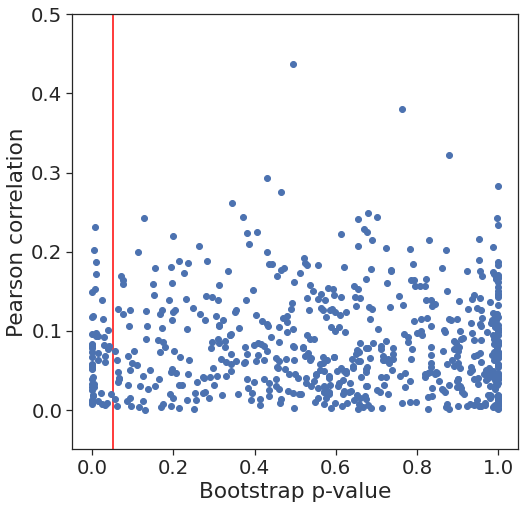

In [16]:
df_plot2 = df_plot.copy()
fig, ax = plt.subplots(figsize=(8,8))
ax.vlines(0.05, -.1, 1.1, "red")
ax.plot(df_plot2["pval_traitAssoc"],df_plot2["pearson"], "o")
ax.set_ylabel("Pearson correlation")
ax.set_xlabel("Bootstrap p-value")
ax.set_xlim(-.05,1.05)
ax.set_ylim(-.05,0.5)

In [12]:
# from scipy.stats import pearsonr

# '''
# AGE
# good result? 
# '''

# # Get the correlation of a latent feature with the phenotype
# pheno = "Age"
# print(pheno)
# y_age = whole_dataset["pheno"][pheno]
# y_age = y_age.replace(np.nan, y_age.median())  ## impute missing values for simplicity

# ### Correlation between latActivations (over all patients) and Age
# all_pearson = []
# for i,val in enumerate(latSpace_whole.T):
#     all_pearson.append(np.absolute(pearsonr(val, y_age)[0]))
#     #print(i, pearsonr(val, y))
# df_age_activations = pd.DataFrame(all_pearson, columns=["pearson"]).sort_values(by="pearson", ascending=False)

# ### Latent feature trait association with phenotype
# for i in range(25):
#     ## Load trait associations
#     PATH_traitAssoc = f"results/optLatSize/latSize_25/perturbations/latFeature_{i}/latFeature_traitAssociation_using_EWAS.csv"
#     df_traitAssoc = pd.read_csv(f"{PATH_traitAssoc}", index_col=0)
#     ## Get all traits related to "age" and get mean of pval
#     pval_mean = df_traitAssoc[df_traitAssoc.index.str.contains("age*", case=False)]["pval_bootstrap"].mean()
#     ## add to table
#     df_age_activations.loc[i, "pval_traitAssoc"] = pval_mean

# '''
# SEX
# not too strong interaction, but can take it into paper probably
# '''

# #### Sex
# # Get the correlation of a latent feature with the phenotype
# pheno = "Sex"
# print(pheno)
# y_sex = whole_dataset["pheno"][pheno]
# ## Encode binary; F = 1, M = 0
# dic_encode_y = {"M":0, "F":1, "N":0}
# y_sex_binary = y_sex.replace(dic_encode_y)

# ### Correlation between latActivations (over all patients) and Age
# all_pearson = []
# for i,val in enumerate(latSpace_whole.T):
#     all_pearson.append(np.absolute(pearsonr(val, y_sex_binary)[0]))
#     #print(i, pearsonr(val, y))
# df_sex_activations = pd.DataFrame(all_pearson, columns=["pearson"]).sort_values(by="pearson", ascending=False)

# ### Latent feature trait association with phenotype
# for i in range(25):
#     ## Load trait associations
#     PATH_traitAssoc = f"results/optLatSize/latSize_25/perturbations/latFeature_{i}/latFeature_traitAssociation_using_EWAS.csv"
#     df_traitAssoc = pd.read_csv(f"{PATH_traitAssoc}", index_col=0)
#     ## Get all traits related to "age" and get mean of pval
#     pval_mean = df_traitAssoc[df_traitAssoc.index.str.contains("sex", case=False)]["pval_bootstrap"].mean()
#     ## add to table
#     df_sex_activations.loc[i, "pval_traitAssoc"] = pval_mean


Age
Sex


In [14]:
#df_age_activations.round(2)
df_sex_activations.round(2)

,pearson,pval_traitAssoc
22,0.11,0.08
7,0.11,0.84
23,0.10,0.73
18,0.09,0.00
5,0.09,0.07
10,0.07,0.03
11,0.07,0.91
13,0.07,0.48
19,0.06,1.00
1,0.06,0.99


### 3. Part of a cellular pathway?
- AE groups according to cellular functions?

In [87]:
''' 
Run in external script (bash script) as it takes some time. 
Only read in results and analyse here!
'''

## !/usr/lib/R/bin/Rscript scripts/GOenrich.R results/optLatSize/latSize_25/latFeature_0/cpgs_high.txt
## !python associationPipeline_chr22.py --cpgfile results/optLatSize/latSize_25/perturbations/latFeature_0/cpgs_high.txt

# ./scripts/run_pipeline.sh

' \nRun in external script (bash script) as it takes some time. \nOnly read in results and analyse here!\n'

**Retrieve a summary for all latent features per context to get an overview!**

In [43]:
def get_summary_AssociationAna(context, cpgs_sel = "cpgs_high"):
    dic = dict()
    for latFeature_i in range(25):
        df = pd.read_csv(f"results/optLatSize/latSize_25/perturbations/latFeature_{latFeature_i}/{cpgs_sel}/AssociationSummary.csv", index_col=0)
        
        df_tmp = df[df["context"] == context]
        keys = df_tmp[df_tmp["pval"] < 0.05].index
        for i in keys:
            if i in dic.keys():
                dic[i].append(latFeature_i) 
            else: 
                dic[i] = [latFeature_i]
    return dic

### ADD ONTOLOGY FUNCTION
def get_summary_BP(cpgs_sel = "cpgs_high"):
    dic_BP_latFeature = dict()
    dic_BP_sum = dict()

    for latFeature_i in range(25):
        df = pd.read_csv(f"results/optLatSize/latSize_25/perturbations/latFeature_{latFeature_i}/{cpgs_sel}/AssociationSummary.csv", index_col=0)    

        df_tmp = df[df["TERM"].notna()]
        df_tmp.index = df_tmp["TERM"]
        sigBP = df_tmp[df_tmp["FDR"] < 0.05].index.tolist()

        ### First output: BP per latent feature
        dic_BP_latFeature[latFeature_i] = sigBP

        ### Second output: BP occurences over all latent features
        for i in sigBP:
            if i in dic_BP_sum.keys():
                dic_BP_sum[i].append(latFeature_i) 
            else: 
                dic_BP_sum[i] = [latFeature_i]

    return dic_BP_latFeature, dic_BP_sum

In [83]:
### Genomic context
for context in ["relativeGene", "regulatoryFeature", "relativeIsland", "DHS", "Enhancer"]:
    print(context)
    dic = get_summary_AssociationAna(context, cpgs_sel="cpgs_high") #_medium_low

    df_plot = pd.DataFrame.from_dict(dic, orient="index").T
    print(df_plot.count())

### BP
dic_BP_latFeature, dic_BP_sum = get_summary_BP(cpgs_sel = "cpgs_high_medium_low")
dic_BP_sum

relativeGene
TSS1500    14
1stExon    13
5'UTR       9
3'UTR       6
Body        7
TSS200      1
dtype: int64
regulatoryFeature
Series([], dtype: int64)
relativeIsland
N_Shelf    3
Island     1
dtype: int64
DHS
True    7
dtype: int64
Enhancer
True    14
dtype: int64


{'cytidine deaminase activity': [0, 2, 3, 6, 7, 11, 19, 24],
 'pyrimidine nucleoside metabolic process': [0, 2, 3, 6, 7, 11, 14, 19, 24],
 'cytidine catabolic process': [0, 2, 3, 6, 7, 11, 19, 24],
 'ribonucleoside metabolic process': [0],
 'nucleoside catabolic process': [0, 2, 3, 6, 7, 11, 19, 24],
 'cytidine deamination': [0, 2, 3, 6, 7, 11, 19, 24],
 'base conversion or substitution editing': [0, 2, 3],
 'cytidine to uridine editing': [0, 2, 3, 6, 7, 11, 19, 24],
 'hydrolase activity, acting on carbon-nitrogen (but not peptide) bonds, in cyclic amidines': [0],
 'deaminase activity': [0],
 'nucleobase-containing small molecule catabolic process': [0,
  2,
  3,
  7,
  11,
  19,
  24],
 'single stranded viral RNA replication via double stranded DNA intermediate': [0,
  2,
  3,
  7,
  11,
  19,
  24],
 'viral RNA genome replication': [0, 2, 3, 7, 19],
 'ribonucleoside catabolic process': [0, 2, 3],
 'DNA deamination': [0, 2, 3, 6, 7, 11, 19, 24],
 'regulation of single stranded viral R

In [85]:
''' 
Addition: supplements plot on BP summary
'''
# dic_BP_latFeature, dic_BP_sum = get_summary_BP(cpgs_sel = "cpgs_high_medium_low")

# df_tmp = pd.DataFrame([dic_BP_sum.keys(),[len(val) for key, val in dic_BP_sum.items()]]).T
# df_tmp.index = df_tmp[0]
# df_tmp.drop(0, axis=1, inplace=True)
# df_tmp = df_tmp.sort_values(1, ascending=False)

# a = [dic_BP_sum[i] for i in df_tmp.index]
# df_tmp["latefeatures"] = a

# df_tmp.to_csv(f"/home/sonja/Downloads/tmp.csv")